## Palm Movement Detection using Optical Flow

This lab is part of [AI for Beginners Curriculum](http://aka.ms/ai-beginners).

Consider [this video](palm-movement.mp4), in which a person's palm moves left/right/up/down on the stable background.

<img src="../images/palm-movement.png" width="30%" alt="Palm Movement Frame"/>

**Your goal** would be to use Optical Flow to determine, which parts of video contain up/down/left/right movements. 

Start by getting video frames as described in the lecture:

Total frames: 242


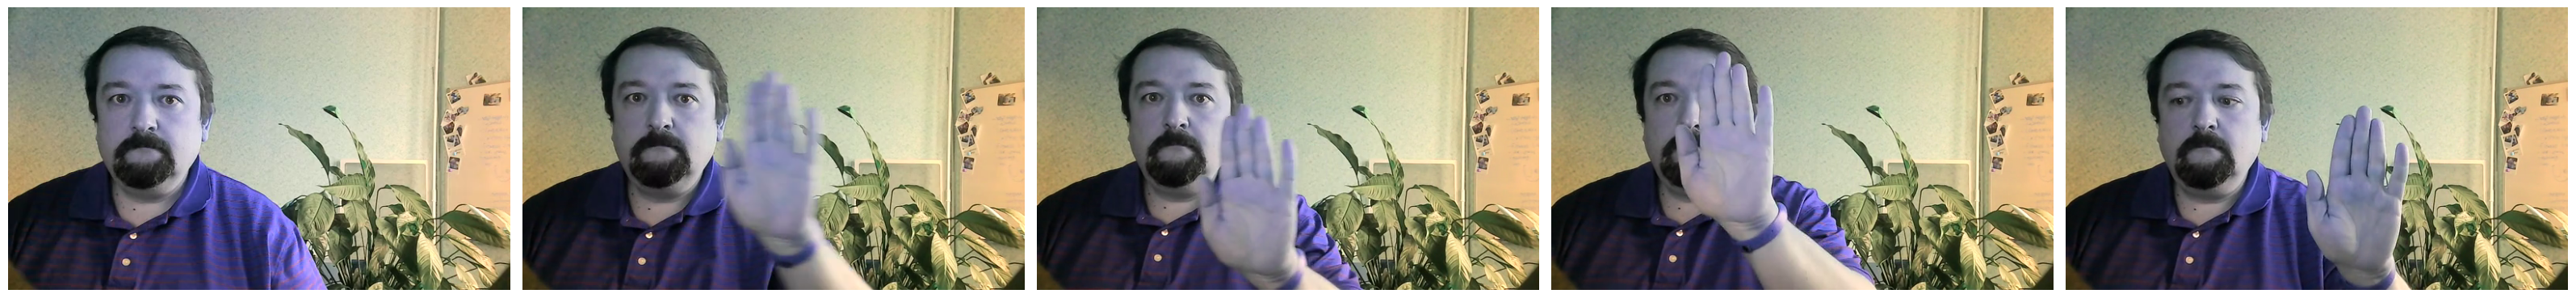

In [32]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()
# Code here
vid = cv2.VideoCapture('./palm-movement.mp4')

c = 0
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)
    c+=1
vid.release()
print(f"Total frames: {c}")
display_images(frames[::60])

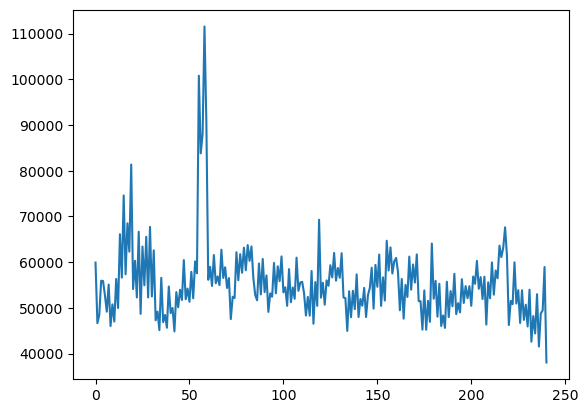

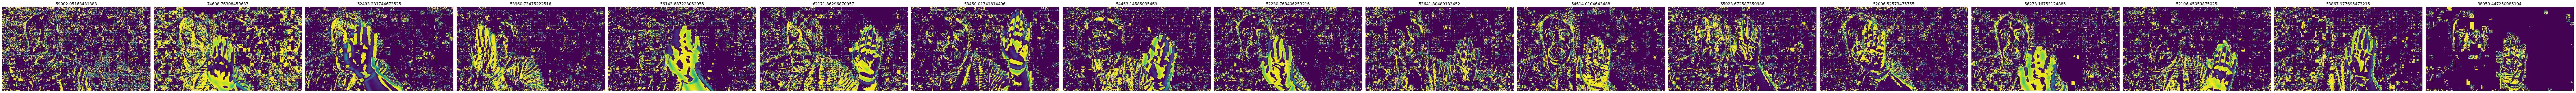

In [34]:
bwframes = [cv2.cvtColor(x,cv2.COLOR_BGR2GRAY) for x in frames]
diffs = [(p2-p1) for p1,p2 in zip(bwframes[:-1],bwframes[1:])]
diff_amps = np.array([np.linalg.norm(x) for x in diffs])
plt.plot(diff_amps)
display_images(diffs[::15],titles=diff_amps[::15])

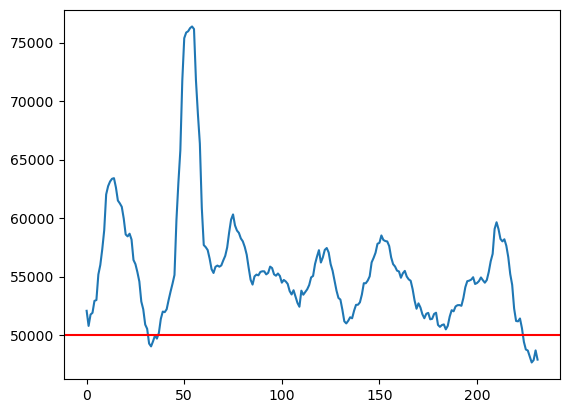

In [35]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

threshold = 50000

plt.plot(moving_average(diff_amps,10))
plt.axhline(y=threshold, color='r', linestyle='-')

In [51]:
active_frames = np.where(diff_amps>threshold)[0]
print(active_frames)

def subsequence(seq, min_length=10):
    result = []
    ss = []

    for i, x in enumerate(seq):
        ss.append(x)
        
        # If the sequence breaks (i.e., the next element is not consecutive)
        if i == len(seq) - 1 or seq[i + 1] != x + 1:
            if len(ss) >= min_length:
                result.extend(ss)  # Add the valid subsequence to result
            ss.clear()  # Reset for the next subsequence

    return result  # Return a single flattened list



sub = subsequence(active_frames)
print(sub)


[  0   3   4   5   7   9  11  13  14  15  16  17  18  19  20  21  22  23
  25  26  27  28  29  30  31  35  39  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 113 115 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 135 137 139 141 142 143 145 146 147 149 150 151 152
 153 154 155 156 157 158 159 160 161 163 165 166 167 168 169 170 171 172
 173 175 177 179 180 181 183 187 189 190 191 193 195 196 197 198 199 200
 201 202 203 204 205 206 207 209 210 211 212 213 214 215 216 217 218 219
 221 222 223 224 225 227 229 231 235 239]
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,

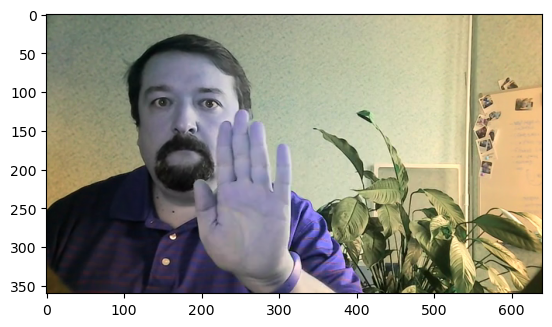

In [52]:
plt.imshow(frames[(sub[0]+sub[-1])//2])

Now, calculate dense optical flow frames as described in the lecture, and convert dense optical flow to polar coordinates: 

13 219


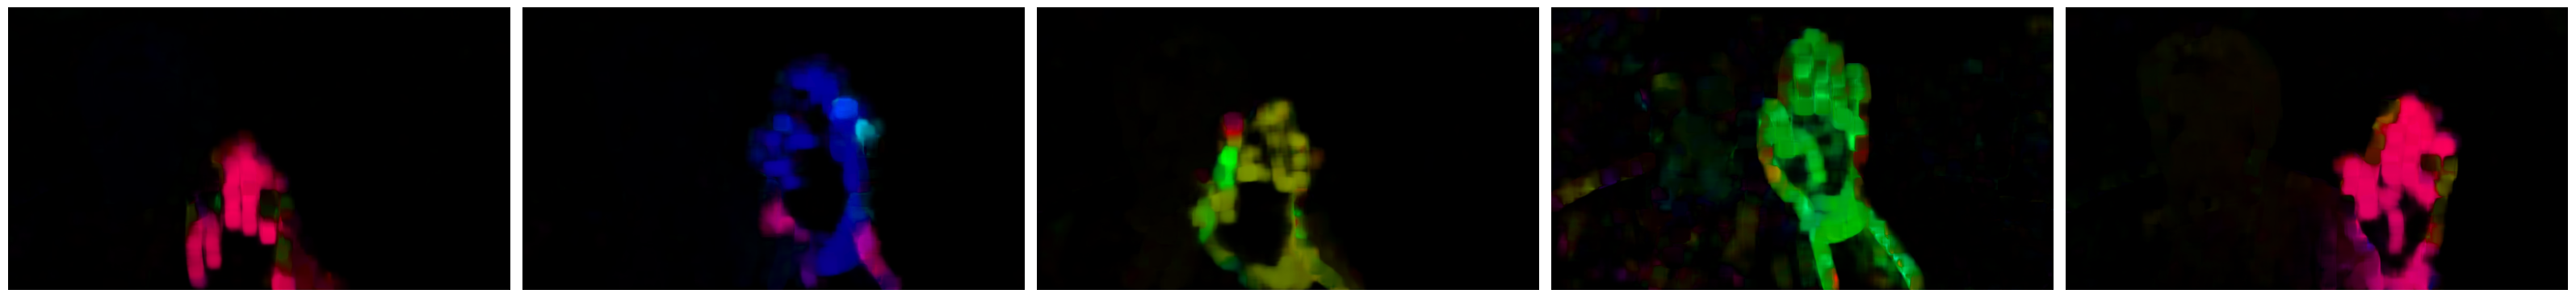

In [54]:
# Code here
flows = [cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 3, 15, 3, 5, 1.2, 0) 
         for f1,f2 in zip(bwframes[:-1],bwframes[1:])]
flows[0].shape
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)

start = sub[0]
stop = sub[-1]
print(start,stop)

frms = [flow_to_hsv(x) for x in flows[start:stop]]
display_images(frms[::50])

Build histogram of directions for each of the optical flow frame. A histogram shows how many vectors fall under certain bin, and it should separate out different directions of movement on the frame.

> You may also want to zero out all vectors whose magnitude is below certain threshold. This will get rid of small extra movements in the video, such as eyes and head.

Plot the histograms for some of the frames.

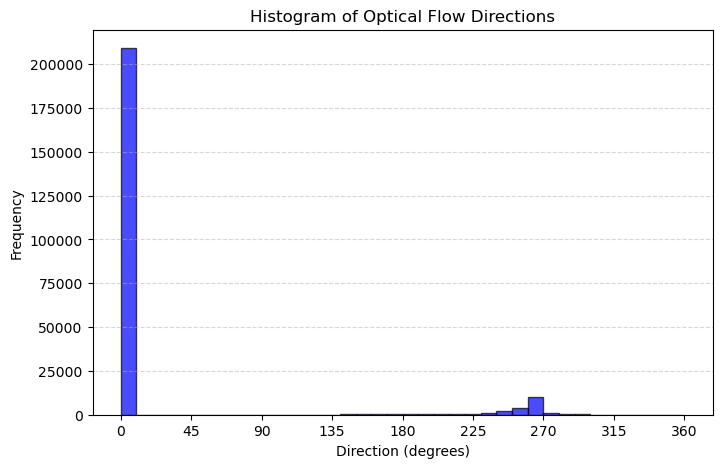

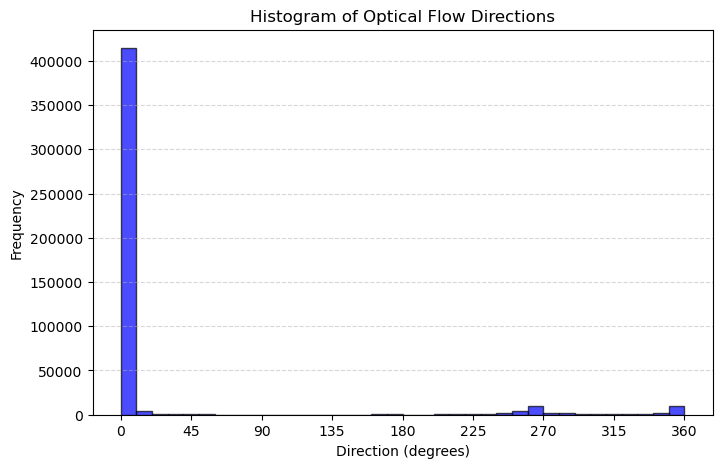

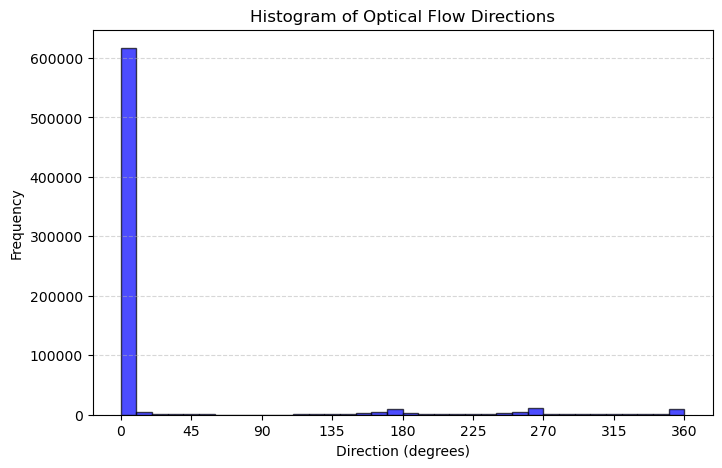

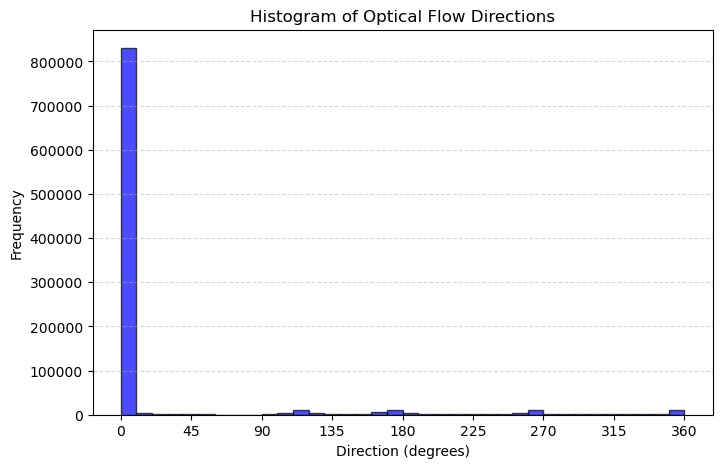

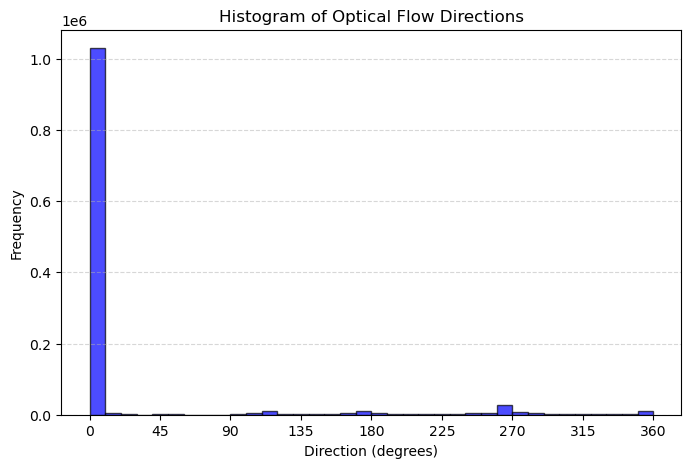

In [58]:
# Code here
# Compute optical flow
flows = [cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 3, 15, 3, 5, 1.2, 0) 
         for f1, f2 in zip(bwframes[:-1], bwframes[1:])]

# Select frames from the detected subsequence
start, stop = sub[0], sub[-1]
selected_flows = flows[start:stop][::50]
MAGNITUDE_THRESHOLD = 1.0  
# Collect angles from all selected flows
angles = []
for flow in selected_flows:
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  # Get magnitude & angle
    #Zero out vectors below threshold
    ang[mag < MAGNITUDE_THRESHOLD] = 0  # Set direction to 0 for low-magnitude flow
    mag[mag < MAGNITUDE_THRESHOLD] = 0  # Optional: Set magnitude to 0 as well
    angles.extend(ang.flatten() * 180 / np.pi)  # Convert radians to degrees & flatten

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(angles, bins=36, range=(0, 360), color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel("Direction (degrees)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Optical Flow Directions")
    plt.xticks(np.arange(0, 361, 45))  # Set ticks at every 45 degrees
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

Looking at histograms, it should be pretty straightforward how to determine direction of movement. You need so select those bins the correspond to up/down/left/right directions, and that are above certain threshold.

In [ ]:
# Code here

Congratulations! If you have done all steps above, you have completed the lab!